## __Tutorial on Gaia Archive Queries__

*prepared by Carine Babusiaux*

In [ ]:
!pip install astroquery

# Table of contents
- [Introduction](#astroquery)
    - [Gaia table names](#tablenames)
    - [GACS login](#login)
- [Example 1: Positional query with epoch propagation](#epochpropa)
- [Example 2: table join query with GSPSpec filters](#gspspec)
- [Example 3: download all datalink info for one source](#datalink)
- [Your turn!](#go)

# Introduction to astroquery.gaia <a href="astroquery"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

## To see all the available Gaia table names  <a name="tablenames"></a>

In [2]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour


## To login to your GACS user account <a name="login"></a>

Not needed for the following. A prompt will ask for the user name and password:

In [3]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: cbabusia
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


You can also use a credential file, see https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#login-logout

Once you are loggued in, you can [upload a file to your user space](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#uploading-table-to-user-space) and for example run a [positional cross-match](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#cross-match) with the Gaia tables.
Note that you need to ensure that you do not have user tables with the same names as the ones you will be using here, else you would need to [delete your old tables](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#deleting-table). Once loggued in, you will see also your tables and the ones shared with you with the Gaia.load_tables command.

# Example 1: Positional query with epoch propagation <a name="epochpropa"></a>

Look if GJ473 is resolved by Gaia. It's Simbad position need to be propagated to the Gaia epoch using EPOCH_PROP_POS, see https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries/#epoch_prop. The following query selects sources within 5" from GJ473 according to its Simbad J2000 information, adapted from the query used by the "Basic Search" GUI: 

In [4]:
queryGJ473 = """SELECT source_id, phot_g_mean_mag, parallax, pmra, pmdec, ruwe
FROM gaiadr3.gaia_source 
WHERE 
CONTAINS(
	POINT('ICRS',ra,dec),
	CIRCLE(
		'ICRS',
		COORD1(EPOCH_PROP_POS(188.3223395,9.0210534,227.9000,-1730.0000,203.0000,1.0000,2000,2016.0)),
		COORD2(EPOCH_PROP_POS(188.3223395,9.0210534,227.9000,-1730.0000,203.0000,1.0000,2000,2016.0)),
		5./3600.)
)=1"""

In [5]:
job = Gaia.launch_job(queryGJ473)
r = job.get_results()
r

<Table length=2>
     source_id      phot_g_mean_mag ...       pmdec           ruwe  
                          mag       ...      mas / yr               
       int64            float32     ...      float64        float32 
------------------- --------------- ... ------------------ ---------
3902874650601954816       11.240162 ... 203.09780864044555 13.949631
3902874650602495232       11.235116 ... 217.78856656191624  6.116347

# Example 2: table join query with GSPSpec filters <a name="gspspec"></a>

Perform an asynchronous query (asynchronous rather than synchronous queries should be performed when retrieving more than 2000 rows). Asynchronous queries save results at server side and depends on the user files quota. These queries can be accessed at any time. For anonymous users, results are kept for three days.
Queries retrieved results can be stored locally in memory (by default) or in a file.

Query to get some GSPSpec parameters within the "High quality sample" as defined in Annex B of [Gaia Collaboration, Recio-Blanco A. et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...674A..38G/abstract)

In [6]:
queryGspSpec = """select top 1000 mh_gspspec, alphafe_gspspec 
FROM gaiadr3.astrophysical_parameters 
JOIN gaiadr3.gaia_source using(source_id) 
WHERE abs(b)>50 AND 
(teff_gspspec>3500) AND (logg_gspspec>0 AND 
logg_gspspec<5) AND (flags_gspspec LIKE '0%') 
AND (flags_gspspec LIKE '_0%') 
AND (flags_gspspec LIKE '__0%') 
AND (flags_gspspec LIKE '___0%') 
AND (flags_gspspec LIKE '____0%') 
AND (flags_gspspec LIKE '_____0%') 
AND (flags_gspspec LIKE '______0%')  
AND ((flags_gspspec LIKE '_______0%') OR (flags_gspspec LIKE '_______1%') OR (flags_gspspec LIKE '_______2%') ) 
AND ((flags_gspspec LIKE '____________0%') OR (flags_gspspec LIKE '____________1%') )  
AND (flags_gspspec LIKE '________0%') 
AND (flags_gspspec LIKE '_________0%') 
AND (flags_gspspec LIKE '__________0%') 
AND (flags_gspspec LIKE '___________0%')"""

Launch query without saving results in a file:

In [7]:
job     = Gaia.launch_job_async(queryGspSpec)
results = job.get_results()
print(f'Table size (rows): {len(results)}')

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 1000


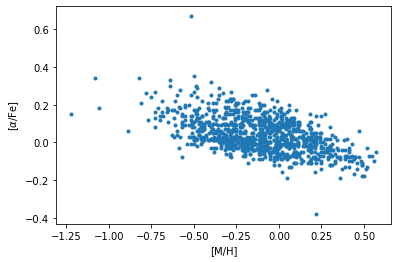

In [8]:
plt.plot(results['mh_gspspec'], results['alphafe_gspspec'], '.')
plt.xlabel('[M/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.show()

With such an asynchronous query, your job is stored on your user account, so don't forget to remove it once you are done: 

In [9]:
Gaia.remove_jobs(job.jobid)

Removed jobs: '1694703952279O'.


# Example 3: download all datalink info for one source <a name="datalink"></a>
We take here the Cepheid BF Oph (Gaia DR3 4111834567779557376) which is the "Single Object" default example of the GUI. 

In [10]:
datalink = Gaia.load_data(ids="4111834567779557376", retrieval_type='ALL', output_file = None)
datalink.keys()

dict_keys(['RVS-Gaia DR3 4111834567779557376.xml', 'MCMC_GSPPHOT-Gaia DR3 4111834567779557376.xml', 'XP_CONTINUOUS-Gaia DR3 4111834567779557376.xml', 'MCMC_MSC-Gaia DR3 4111834567779557376.xml', 'XP_SAMPLED-Gaia DR3 4111834567779557376.xml', 'EPOCH_PHOTOMETRY-Gaia DR3 4111834567779557376.xml'])

The XP sampled and RVS products consist in a table that is serialised following the [IVOA Spectrum Data Model](https://www.ivoa.net/documents/SpectrumDM/) (see for details the [DataLink Products serialisation tutorial](https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products#datalink_serialisation)). As a result, a number of parameters (including the source_id) associated to these files is stored in the table metadata. The cell below shows, using RVS Spectra as an example, how to extract these parameters, and how to export the table content to an Astropy Table object.

In [11]:
dl_key      = list(datalink.keys())[0]
print(dl_key)

RVSproduct = datalink[dl_key][0]
print("\nContent:")
items    = [item for item in RVSproduct.iter_fields_and_params()]
for item in items:
        print(item)
        
print("\nFirst 5 lines:")
print(RVSproduct.to_table()[0:5])

RVS-Gaia DR3 4111834567779557376.xml

Content:
<PARAM ID="source_id" datatype="long" name="source_id" ucd="meta.id;meta.main" value="4111834567779557376"/>
<PARAM ID="solution_id" datatype="long" name="solution_id" ucd="meta.version" value="5950420259779346465"/>
<PARAM ID="combined_transits" datatype="int" name="combined_transits" ucd="meta.number" value="31"/>
<PARAM ID="combined_ccds" datatype="int" name="combined_ccds" ucd="meta.number" value="92"/>
<PARAM ID="deblended_ccds" datatype="int" name="deblended_ccds" ucd="meta.number" value="0"/>
<PARAM ID="spatialLocation" arraysize="2" datatype="double" name="spatialLocation" ucd="pos.eq" unit="deg" utype="spec:Char.SpatialAxis.Coverage.Location.Value" value="[256.5229102  -26.58056513]"/>
<PARAM ID="TimeAxisCoverageLocation" datatype="double" name="TimeAxisCoverageLocation" ucd="time.epoch" unit="yr" utype="spec:Char.TimeAxis.Coverage.Location.Value" value="2016.0"/>
<PARAM ID="TimeAxisCoverageBoundsExtent" datatype="double" name="Ti

# Learn more 

astroquery.gaia documentation page: https://astroquery.readthedocs.io/en/latest/gaia/gaia.html

GACS demo and tutorials: https://www.cosmos.esa.int/web/gaia-users/archive/help.
In particular:
- ADQL Query Examples: https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries#ADQLQueryExamples
- A DataLink tutorial: https://www.cosmos.esa.int/web/gaia-users/archive/use-cases#datalink_dr3_pleiades
- Tutorial to retrieve large amounts (data for more than 5000 sources) of DataLink products : https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products#datalink_jntb_get_above_lim

# Your turn ! <a name="go"></a>

* Using the "Query examples" that you can find on the top right corner of the "Advanced (ADQL)" tab of the Gaia Archive, plot a colour-colour diagram of the 2MASS J-K colour versus the Gaia bp_rp of the golden sample of ultra-cool dwarfs (gaiadr3.gold_sample_ucd)

In [12]:
query = """SELECT bp_rp, tmass.j_m-tmass.ks_m as JmK
FROM gaiadr3.gold_sample_ucd
JOIN gaiadr3.gaia_source USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE tmass.ph_qual = 'AAA'
""" 
job = Gaia.launch_job_async(query)
Gaia.remove_jobs(job.jobid)
results = job.get_results()
len(results)

INFO: Query finished. [astroquery.utils.tap.core]


21062

Removed jobs: '1694703961418O'.


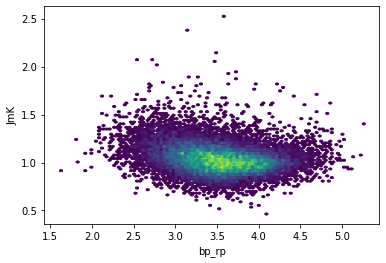

In [13]:
plt.hexbin(results['bp_rp'],results['JmK'],mincnt=1)
plt.xlabel('bp_rp')
plt.ylabel('JmK')

* Try your favourite queries !